In [76]:
import pandas as pd
import random
from datetime import datetime
import geopandas
from pytz import timezone
import pytz
import geopy
from geopy import distance
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [94]:
#p = 0.01  # 1% of the lines
#df = pd.read_csv("D:/CSE519/all/train.csv", header=0, skiprows=lambda i: i>0 and random.random() > p)
ROWS=900000
df = pd.read_csv("D:/CSE519/all/train.csv", nrows=ROWS)
df2=df
df3=df
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [80]:
def dataCleaningAndaddSomeFearture(df):
    df = df.dropna()
    TimeArray= pd.to_datetime(df['pickup_datetime']).dt.tz_localize('utc').dt.tz_convert('America/New_York')
    df.insert(df.shape[1],'pickup_easternTime',TimeArray)
    df.drop(['pickup_datetime'],axis=1,inplace=True)
    
    dateTime=pd.DatetimeIndex(df['pickup_easternTime'])
    df.insert(df.shape[1],'year',dateTime.year)
    df.insert(df.shape[1],'dayofweek',dateTime.dayofweek)
    df.insert(df.shape[1],'hour',dateTime.hour)
    df.insert(df.shape[1],'minute',dateTime.minute)
    timeofday=df['hour']+df['minute']/60
    df.insert(df.shape[1],'timeofday',timeofday)   
  
     
    df_fare_filter = df.loc[ (df['fare_amount']>2.5) & (df['passenger_count']>0) & (df['passenger_count']<=6)]
    #Raleigh,NC (SOUTH point) 35.7796° N, 78.6382° W Boston, MA (NORTH point) 42.3601° N, 71.0589° W Philadelphia, PA(WEST point) 39.9526° N, 75.1652° W Montauk, NY (EAST point) 41.0359° N, 71.9545° W
    south= 35.7796
    north= 42.3601
    west= -75.1652
    east= -71.9545
    df_location_MiddleFilter=df_fare_filter.loc[   (df_fare_filter['pickup_longitude']>west) \
                                        & (df_fare_filter['pickup_longitude']<east)\
                                        & (df_fare_filter['pickup_latitude']>south)\
                                        & (df_fare_filter['pickup_latitude']<north)\
                                        & (df_fare_filter['dropoff_longitude']>west)\
                                        & (df_fare_filter['dropoff_longitude']<east)\
                                        & (df_fare_filter['dropoff_latitude']>south)\
                                        & (df_fare_filter['dropoff_latitude']<north)]
    df_fare_filter=df_location_MiddleFilter
    #South Amboy, NJ (SOUTH point) 40.4779°, -74.2907° \ Paterson NJ (NORTH point) -40.9168° , -74.1718° \ Perth Amboy, NJ (WEST point) 40.5068°, -74.2654° \ Garden City NY (EAST point) 40.7268° , -73.6343°
     
    # range of longitude and latitude of NYC 
    
    south 40.495992
    north 40.915568 
    west -74.257159
    east -73.699215
    df_location_filter=df_fare_filter.loc[  ( (df_fare_filter['pickup_longitude']>west) \
                                        & (df_fare_filter['pickup_longitude']<east)\
                                        & (df_fare_filter['pickup_latitude']>south)\
                                        & (df_fare_filter['pickup_latitude']<north))\
                                        | ((df_fare_filter['dropoff_longitude']>west)\
                                        & (df_fare_filter['dropoff_longitude']<east)\
                                        & (df_fare_filter['dropoff_latitude']>south)\
                                        & (df_fare_filter['dropoff_latitude']<north))]
    return df_location_filter
                                     

In [50]:
JFK=(40.6413, -73.7781)
MANHATTAN=(40.7831, -73.9712)
NEWARK=(40.7357, -74.1724)

def travelDistance(df):
    coord1=(df['pickup_latitude'], df['pickup_longitude'])
    coord2=(df['dropoff_latitude'], df['dropoff_longitude'])
    return geopy.distance.vincenty(coord1, coord2).miles

def pickupDistanceToJFK(x):
    coords=(x['pickup_latitude'], x['pickup_longitude'])
    return geopy.distance.vincenty(JFK, coords).miles
    
def dropoffDistanceToJFK(x):
    coords=(x['dropoff_latitude'], x['dropoff_longitude'])
    return geopy.distance.vincenty(JFK, coords).miles
    
def pickupDistanceToManhattan(x):
    coords=(x['pickup_latitude'], x['pickup_longitude'])
    return geopy.distance.vincenty(MANHATTAN, coords).miles  

def dropoffDistanceToManhattan(x):
    coords=(x['dropoff_latitude'], x['dropoff_longitude'])
    return geopy.distance.vincenty(MANHATTAN, coords).miles  

def dropoffDistanceToNewark(x):
    coords=(x['dropoff_latitude'], x['dropoff_longitude'])
    return geopy.distance.vincenty(NEWARK, coords).miles  

In [48]:
def addNewFeatures(df):
    travelDistanceArray=df.apply(travelDistance, axis=1)
    if 'travelDistance' in df.columns:
        df.drop(['travelDistance'],axis=1,inplace=True)
    df.insert(df.shape[1],'travelDistance',travelDistanceArray)
    #JFK
    pickup_jfkArray=df.apply(pickupDistanceToJFK, axis=1)
    if 'pickup_jfk' in df.columns:
        df.drop(['pickup_jfk'],axis=1,inplace=True)
    df.insert(df.shape[1],'pickup_jfk',pickup_jfkArray)
    
    dropoff_jfkArray=df.apply(dropoffDistanceToJFK,axis=1)
    if 'dropoff_jfk' in df.columns:
        df.drop(['dropoff_jfk'],axis=1,inplace=True)
    df.insert(df.shape[1],'dropoff_jfk',dropoff_jfkArray)
    #Manhattan
    pickup_manhattanArray=df.apply(pickupDistanceToManhattan,axis=1)
    if 'pickup_manhattan' in df.columns:
        df.drop(['pickup_manhattan'],axis=1,inplace=True)
    df.insert(df.shape[1],'pickup_manhattan',pickup_manhattanArray)
    
    dropoff_manhattanArray=df.apply(dropoffDistanceToManhattan,axis=1)
    if 'dropoff_manhattan' in df.columns:
        df.drop(['dropoff_manhattan'],axis=1,inplace=True)
    df.insert(df.shape[1],'dropoff_manhattan',dropoff_manhattanArray)
    #Newark
    dropoff_newarkArray=df.apply(dropoffDistanceToNewark,axis=1)
    if 'dropoff_newark' in df.columns:
        df.drop(['dropoff_newark'],axis=1,inplace=True)
    df.insert(df.shape[1],'dropoff_newark',dropoff_newarkArray)
    

In [7]:
def furtherClean(df):
    df_clean2= df_clean.loc[df_clean['fare_amount']>=2.8+df_clean['travelDistance']*2.5]
    df_clean3=df_clean2.loc[(df_clean2['travelDistance']>10) | (df_clean2['fare_amount']<100)]
    df_clean4= df_clean3.loc[ (df_clean3['travelDistance']!=0 )| (df_clean3['fare_amount']==0)]
    return df_clean4
    

In [116]:
df.shape

(900000, 8)

In [117]:
df=dataCleaningAndaddSomeFearture(df)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [118]:
df.shape

(874543, 13)

In [126]:
addNewFeatures(df)

In [127]:
df.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_easternTime,year,dayofweek,hour,minute,timeofday,travelDistance,pickup_jfk,dropoff_jfk,pickup_manhattan,dropoff_manhattan,dropoff_newark
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 13:26:21-04:00,2009,0,13,26,13.433333,0.639764,6.525606,5.926067,7.906224,8.374388,17.440404
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 11:52:16-05:00,2010,1,11,52,11.866667,5.246511,13.401180,14.346804,5.484811,0.429876,10.625267
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-17 20:35:00-04:00,2011,2,20,35,20.583333,0.863167,13.565196,13.496117,1.623390,2.479228,9.562611
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 00:30:42-04:00,2012,5,0,30,0.500000,1.737223,12.677118,13.806452,3.547060,2.029625,9.614833
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 02:51:00-05:00,2010,1,2,51,2.850000,1.241710,13.265834,13.584036,1.054054,0.764251,11.795638


In [129]:
Model1='geopyvincenty'
Model2="scipy.cityblock"
Model3="starter"
df.reset_index().to_feather('D:/CSE519/all/df'+str(ROWS)+"_"+Model1)
df=pd.read_feather('D:/CSE519/all/df'+str(ROWS)+'_'+Model1)

In [87]:
ROWS=900000
Model1='geopyvincenty'
df_clean=pd.read_feather('D:/CSE519/all/df'+str(ROWS)+'_'+Model1)

In [88]:
df_clean=furtherClean(df_clean)  

In [89]:
df_clean.describe()

,index,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,dayofweek,hour,minute,timeofday,travelDistance,pickup_jfk,dropoff_jfk,pickup_manhattan,dropoff_manhattan,dropoff_newark
count,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000,775554.000000
mean,450292.656078,11.983523,-73.975380,40.750410,-73.974631,40.750343,1.699989,2011.850364,2.971500,11.796250,29.541151,12.288603,2.153255,12.941037,12.966243,2.786168,2.915443,10.623777
std,259791.258659,9.793014,0.035203,0.026919,0.035207,0.030985,1.313639,1.872314,1.896171,5.773802,17.319029,5.767960,2.287309,1.852277,1.737637,2.058424,2.150795,1.967060
min,0.000000,2.900000,-74.438233,40.459543,-74.703679,40.253758,1.000000,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000052,0.101878,0.115198,0.003304,0.004376,0.078353
25%,225379.250000,6.500000,-73.992397,40.736107,-73.991757,40.734592,1.000000,2010.000000,1.000000,7.000000,14.000000,7.533333,0.830557,12.798280,12.762480,1.422287,1.462811,9.553842
50%,450468.500000,8.900000,-73.982236,40.753070,-73.980953,40.753236,1.000000,2012.000000,3.000000,12.000000,30.000000,12.633333,1.399160,13.181184,13.172313,2.362162,2.415332,10.222256
75%,675405.750000,13.300000,-73.968788,40.767065,-73.966216,40.767440,2.000000,2013.000000,5.000000,16.000000,45.000000,16.966667,2.527793,13.612889,13.621024,3.663107,3.816943,11.179462
max,899999.000000,495.000000,-73.528895,41.003890,-72.196091,41.525883,6.000000,2015.000000,6.000000,23.000000,59.000000,23.983333,87.514694,42.277818,86.781647,28.433494,94.278352,105.258203


# Part2. (1) Compute the Pearson correlation between Euclidean distance of the ride and the taxi fare

In [10]:
df_clean['travelDistance'].corr(df_clean['fare_amount'])

0.8983617092294527

In [11]:
df_clean['timeofday'].corr(df_clean['travelDistance'])

0.028700407872222482

In [12]:
df_clean['timeofday'].corr(df_clean['fare_amount'])

-0.007801330483902239

# Part3.(1) scatter plot of dist and fare_amout

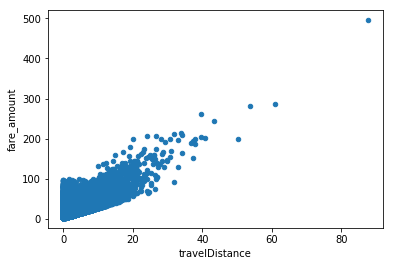

In [13]:
plot3_1=df_clean.plot(kind='scatter',x='travelDistance',y='fare_amount')

# Part3.(b) scatter plot of timeofday and distance

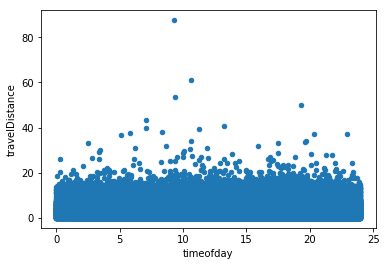

In [14]:
plot3_2=df_clean.plot(kind='scatter',x='timeofday', y='travelDistance')

# Part3.(c) scatter plot of timeofday and fare_amount

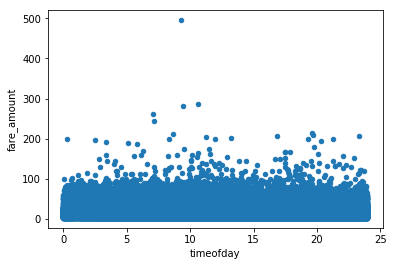

In [15]:
plot3_3=df_clean.plot(kind='scatter',x='timeofday', y='fare_amount')

In [16]:
def convertCategory(df_clean):    
    # set the variables
    df_clean['isWeekday'] = -1
    df_clean.loc[(df_clean['dayofweek'] >= 0) & (df_clean['dayofweek'] <=4), 'isWeekday'] = 1
    df_clean.loc[(df_clean['dayofweek'] >= 5) & (df_clean['dayofweek'] <= 6), 'isWeekday'] = 0
    #
    df_clean['isJFK_Manhattan'] = 0
    df_clean.loc[ ((df_clean['pickup_jfk'] <=1) & (df_clean['dropoff_manhattan'] <=3))\
             | ((df_clean['pickup_manhattan'] <= 3) & (df_clean['dropoff_jfk'] <= 1) ), 'isJFK_Manhattan'] = 1
    #
    df_clean['isToNewark'] = 0
    df_clean.loc[ (df_clean['dropoff_newark'] <=1), 'isToNewark'] = 1
    #
    df_clean['is4pm_8pm'] = 0
    df_clean.loc[ ((df_clean['timeofday']>=16) & (df_clean['timeofday'] <=20) &(df_clean['isWeekday']==1)), 'is4pm_8pm'] = 1
    #
    df_clean['is8pm_6am'] = 0
    df_clean.loc[ ((df_clean['timeofday']>=20) & (df_clean['timeofday'] <=23)) \
             | ((df_clean['timeofday']>=0) &  (df_clean['timeofday']<=6)) , 'is8pm_6am'] = 1
    #
    df_clean['isRushHour'] = 0
    df_clean.loc[ ((df_clean['is4pm_8pm']==1) |((df_clean['timeofday']>=7) & (df_clean['timeofday'] <=9)) &(df_clean['isWeekday']==1))  , 'isRushHour'] = 1
    #Drop some columns again

def deleteUnecessaryColumns(df_clean):
    #drop unecessary columns
    if 'pickup_latlogPair' in df_clean.columns:
        df_clean.drop(['pickup_latlogPair'],axis=1,inplace=True)
    if 'dropoff_latlogPair' in df_clean.columns:
        df_clean.drop(['dropoff_latlogPair'],axis=1,inplace=True)
    if 'pickup_latitude' in df_clean.columns:
        df_clean.drop(['pickup_latitude'],axis=1,inplace=True)
    if 'pickup_longitude' in df_clean.columns:
        df_clean.drop(['pickup_longitude'],axis=1,inplace=True)
    if 'dropoff_latitude' in df_clean.columns:
        df_clean.drop(['dropoff_latitude'],axis=1,inplace=True)
    if 'dropoff_longitude' in df_clean.columns:
        df_clean.drop(['dropoff_longitude'],axis=1,inplace=True)
    if 'passenger_count' in df_clean.columns:
        df_clean.drop(['passenger_count'],axis=1,inplace=True)
    if 'index' in df_clean.columns:
        df_clean.drop(['index'],axis=1,inplace=True)
    if 'pickup_easternTime' in df_clean.columns:
        df_clean.drop(['pickup_easternTime'],axis=1,inplace=True)
    if 'dayofweek' in df_clean.columns:
        df_clean.drop(['dayofweek'],axis=1,inplace=True)
    if 'month' in df_clean.columns:
        df_clean.drop(['month'],axis=1,inplace=True)
    if 'hour' in df_clean.columns:
        df_clean.drop(['hour'],axis=1,inplace=True)
    if 'minute' in df_clean.columns:
        df_clean.drop(['minute'],axis=1,inplace=True)

In [39]:
def AjustFareAmount(df):
    # Metered fare calculation:
    if (df['isJFK_Manhattan']==0): # metered fare
        df['fare_amount']=df['fare_amount']-2.8 # base charge
        if (df['is4pm_8pm']==1):
            df['fare_amount']=df['fare_amount']-1
        if (df['is8pm_6am']==1):
            df['fare_amount']=df['fare_amount']-0.5
    #if (df['isJFK_Manhattan']==1):
        #df['fare_amount']
    if(df['isToNewark']==1):
        df['fare_amount']=df['fare_amount']-17.5-0.3-11 # 11 toll fee 
        # consider metered Rule
        if (df['is4pm_8pm']==1):
            df['fare_amount']=df['fare_amount']-1
        if (df['is8pm_6am']==1):
            df['fare_amount']=df['fare_amount']-0.5
    

    return df    
    
    

In [40]:
convertCategory(df_clean)

In [41]:
df_regression = df_clean.loc[df_clean['isJFK_Manhattan']==0]
deleteUnecessaryColumns(df_regression)
df_regression.describe()
# adjust the fare amount first


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,fare_amount,year,timeofday,travelDistance,pickup_jfk,dropoff_jfk,pickup_manhattan,dropoff_manhattan,dropoff_newark,isWeekday,isJFK_Manhattan,isToNewark,is4pm_8pm,is8pm_6am,isRushHour
count,766712.000000,766712.000000,766712.000000,766712.000000,766712.000000,766712.000000,766712.000000,766712.000000,766712.000000,766712.000000,766712.0,766712.000000,766712.000000,766712.000000,766712.000000
mean,11.517397,2011.848264,12.308084,2.028566,13.022812,13.023025,2.717870,2.871726,10.572728,0.742452,0.0,0.000025,0.157907,0.259708,0.230174
std,8.812982,1.872398,5.769652,1.980667,1.554399,1.517402,1.864623,2.027778,1.832832,0.437284,0.0,0.004978,0.364654,0.438474,0.420944
min,2.900000,2008.000000,0.000000,0.000052,0.101878,0.115198,0.003304,0.004376,0.078353,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,6.500000,2010.000000,7.533333,0.825285,12.805416,12.769183,1.418517,1.460439,9.548834,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,8.900000,2012.000000,12.666667,1.383138,13.186239,13.175259,2.349466,2.414223,10.215049,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,13.000000,2013.000000,16.983333,2.465844,13.614910,13.622506,3.635685,3.804560,11.156953,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
max,495.000000,2015.000000,23.983333,87.514694,42.277818,86.781647,28.433494,94.278352,105.258203,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [35]:
print(df_regression['is8pm_6am'][0]==0)

True


In [42]:
df_regression=df_regression.apply(AjustFareAmount,axis=1)
df_regression.describe()

,fare_amount,year,timeofday,travelDistance,pickup_jfk,dropoff_jfk,pickup_manhattan,dropoff_manhattan,dropoff_newark,isWeekday,isJFK_Manhattan,isToNewark,is4pm_8pm,is8pm_6am,isRushHour
count,766712.000000,766712.000000,766712.000000,766712.000000,766712.000000,766712.000000,766712.000000,766712.000000,766712.000000,766712.000000,766712.0,766712.000000,766712.000000,766712.000000,766712.000000
mean,8.428918,2011.848264,12.308084,2.028566,13.022812,13.023025,2.717870,2.871726,10.572728,0.742452,0.0,0.000025,0.157907,0.259708,0.230174
std,8.813003,1.872398,5.769652,1.980667,1.554399,1.517402,1.864623,2.027778,1.832832,0.437284,0.0,0.004978,0.364654,0.438474,0.420944
min,-26.300000,2008.000000,0.000000,0.000052,0.101878,0.115198,0.003304,0.004376,0.078353,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,3.300000,2010.000000,7.533333,0.825285,12.805416,12.769183,1.418517,1.460439,9.548834,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,5.700000,2012.000000,12.666667,1.383138,13.186239,13.175259,2.349466,2.414223,10.215049,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,10.100000,2013.000000,16.983333,2.465844,13.614910,13.622506,3.635685,3.804560,11.156953,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
max,492.200000,2015.000000,23.983333,87.514694,42.277818,86.781647,28.433494,94.278352,105.258203,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


# Linear regression

Coefficients: 
 [[3.88196748]]
Mean squared error: 18.69
Variance score: 0.76


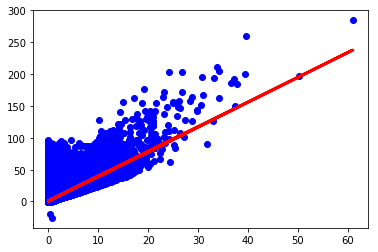

In [43]:
dataFrame_size=df_regression.shape[0];
train= df_regression[:int(dataFrame_size*0.7)]
test=df_regression[int(dataFrame_size*0.3): dataFrame_size-1]




train_x = list(map(lambda x: [x], list(train.travelDistance)))
train_y = list(map(lambda x: [x], list(train.fare_amount)))
test_x = list(map(lambda x: [x], list(test.travelDistance)))
test_y = list(map(lambda x: [x], list(test.fare_amount)))
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
fare_predict = regr.predict(test_x)

# The coefficients
print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_y, fare_predict))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_y, fare_predict))
plt.scatter(test_x, test_y,  color='blue')
plt.plot(test_x, fare_predict, color='red', linewidth=3)

#plt.xticks(())
#plt.yticks(())

plt.show()



In [46]:
def testDataPreprocess(df):    
    TimeArray= pd.to_datetime(df['pickup_datetime']).dt.tz_localize('utc').dt.tz_convert('America/New_York')
    df.insert(df.shape[1],'pickup_easternTime',TimeArray)
    df.drop(['pickup_datetime'],axis=1,inplace=True)
    
    dateTime=pd.DatetimeIndex(df['pickup_easternTime'])
    df.insert(df.shape[1],'year',dateTime.year)
    df.insert(df.shape[1],'dayofweek',dateTime.dayofweek)
    df.insert(df.shape[1],'hour',dateTime.hour)
    df.insert(df.shape[1],'minute',dateTime.minute)
    timeofday=df['hour']+df['minute']/60
    df.insert(df.shape[1],'timeofday',timeofday)  

In [74]:
def AjustTestFareAmount(df):
    if (df['isJFK_Manhattan']==0): # metered fare
        df['fare_amount']=df['fare_amount']+2.8 # base charge
    if (df['is4pm_8pm']==1):
        df['fare_amount']=df['fare_amount']+1
    if (df['is8pm_6am']==1):
        df['fare_amount']=df['fare_amount']+0.5
    #if (df['isJFK_Manhattan']==1):
        #df['fare_amount']
    if(df['isToNewark']==1):
        df['fare_amount']=df['fare_amount']+17.5+0.3+11 # 11 toll fee 
        # consider metered Rule
        if (df['is4pm_8pm']==1):
            df['fare_amount']=df['fare_amount']+1
        if (df['is8pm_6am']==1):
            df['fare_amount']=df['fare_amount']+0.5
    if (df['isJFK_Manhattan']==1):
        if (df['year']>=2014):
            df['fare_amount']=52
        if(df['year']<2014):
            df['fare_amount']=45
    
    return df    




In [75]:
test_df = pd.read_csv("D:/CSE519/all/test.csv")
testDataPreprocess(test_df)
addNewFeatures(test_df)
convertCategory(test_df)
deleteUnecessaryColumns(test_df)
test_X = list(map(lambda x: [x], list(test_df.travelDistance)))
fare_predict = regr.predict(test_X).round(decimals = 2) 
test_df.insert(test_df.shape[1],'fare_amount',fare_predict)
test_df=test_df.apply(AjustTestFareAmount,axis=1)
fare_amount = list(map(lambda x: [x], list(test_df.fare_amount)))
fare_amount=np.array(fare_amount)
print(fare_amount)
#print('\n')
submission = pd.DataFrame({'key': test_df.key,'fare_amount': fare_amount.ravel()},columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

[[ 8.95]
 [ 9.2 ]
 [ 4.85]
 ...
 [49.71]
 [23.97]
 [ 6.21]]


# USE Other model of calculating distances

In [95]:
df2.shape

(900000, 8)

In [96]:
df2=dataCleaningAndaddSomeFearture(df2)
df2.shape

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(874543, 13)

In [ ]:
#JFK terminal_1: 40.643361, -73.789216
#JFK terminal_2_3 : 40.643361,  -73.789216
#JFK terminal_4: 40.643948, -73.782351
#JFK terminal_5: 40.645815, -73.775291
#JFK terminal_6  40.641311, -73.778139
#JFK terminal_7 40.641311, -73.778139
#JFK terminal_8 40.646757, -73.7887979
def isJFK(df):
    